Single spillover (non-recurrent) with finite population, death, and SIS dynamics.

In [72]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
#class representing one simulation.

class Sim:
    def __init__(self, outcome, times, betas, gammas, I, S):
        
        #0 if extinction, 1 if outbreak, None otherwise. 
        self.outcome = outcome 
        
        #the number of events in the simulation
        self.length = len(times)
        
        #these are all arrays of the same length
        self.times = times #all the times of new events (infections and recoveries, including spillover infections)
        self.betas = betas #the corresponding betas. if the event was a recovery, the corresponding beta is "None"
        self.gammas = gammas #the corresponding gammas. if the event was a recovery, the corresponding gamma is "None"
        self.I = I #the number of infecteds, inclusive of the new event
        self.S = S #the number of susceptibles, inclusive of the new event
        

In [74]:
def sim_finite(S_0, beta_0, gamma_0, mu_1=0, mu_2=0, t_thresh = 1000):

    t=0
        
    #stuff to fill and return as part of Sim object.
    all_times = np.array([t])
    all_betas = np.array([beta_0])
    all_gammas = np.array([gamma_0])
    all_I = np.array([1])
    all_S = np.array([S_0])
    
    #initialize counters
    S = S_0; I = 1
        
    #initialize variables to keep track of sums of beta, gamma over all currently infected people    
    beta_sum = beta_0; gamma_sum = gamma_0
        
    #initialize matrix of active cases. each case is a row of length 3.
    # each row looks like [beta, gamma, time of infection] of that person. 
    infecteds=np.array([[beta_0, gamma_0, t]])
    
    while True:
        
        total_pop = S + I #total population
        
        #grab array of all betas and array of all gammas
        betas = infecteds[:,0]; gammas = infecteds[:,1]
        
        #adjust betas to actual transmission rates, which depend on proportion of population that is susceptible
        trans_rates = betas*S/total_pop
        trans_rates_sum = beta_sum*S/total_pop #sum all trans rates
        
        #compute interevent time (for the whole population)
        
        #rate of events is sum of transmission rate and gamma over all infected people
        overall_rate = trans_rates_sum + gamma_sum
        
        #draw from exponential distribution with this rate
        dt = np.random.exponential(scale=1/overall_rate)
        t += dt
        
        #return if next event is after t_thresh
        if t > t_thresh:
            return Sim(None, all_times, all_betas, all_gammas, all_I, all_S)
        
        #figure out who the event happened to
        i = np.random.choice(I, p=(trans_rates+gammas)/overall_rate) #index of that person
        
        #grab their specific transmission rate and beta and gamma
        beta = betas[i]; gamma = gammas[i]
        
        #compute transmission rate
        trans_rate = beta*S/total_pop
        
        #figure out what they did, transmit, recover, or die
        ev = np.random.rand() #draw from uniform distribution over [0, 1)
        prob_trans = trans_rate / (trans_rate + gamma) #probability of transmission
        
        if (ev < prob_trans): #transmission

            #pick beta, gamma for new case
            #mutation is a number drawn from normal distribution with std dev mu_1 or mu_2
            #don't allow negative beta.
            #don't allow gamma to be negative.
            mut1 = np.random.normal(loc=0.0, scale=mu_1)
            new_beta = max(0, beta + mut1)
            mut2 = np.random.normal(loc=0.0, scale=mu_2)
            new_gamma = max(0, gamma + mut2)

            #append new case to infecteds array
            infecteds = np.append(infecteds, [[new_beta, new_gamma, t]], axis=0)
            
            #update running sums
            beta_sum += new_beta; gamma_sum += new_gamma
            
            #update counters
            I += 1; S -= 1
            
            #update return arrays
            all_times = np.append(all_times, t)
            all_betas = np.append(all_betas, new_beta)
            all_gammas = np.append(all_gammas, new_gamma)
            all_I = np.append(all_I, I)
            all_S = np.append(all_S, S)
    
        else: #recovery
            
            #delete them from infecteds array
            infecteds = np.delete(infecteds, i, axis=0)
            
            #update running sums
            beta_sum -= beta; gamma_sum -= gamma
            
            #update counters
            I -= 1; S += 1
            
            #update return arrays
            all_times = np.append(all_times, t)
            all_betas = np.append(all_betas, None)
            all_gammas = np.append(all_gammas, None)
            all_I = np.append(all_I, I)
            all_S = np.append(all_S, S)
            
            #check for extinction
            if I == 0:
                return Sim(0, all_times, all_betas, all_gammas, all_I, all_S)

None


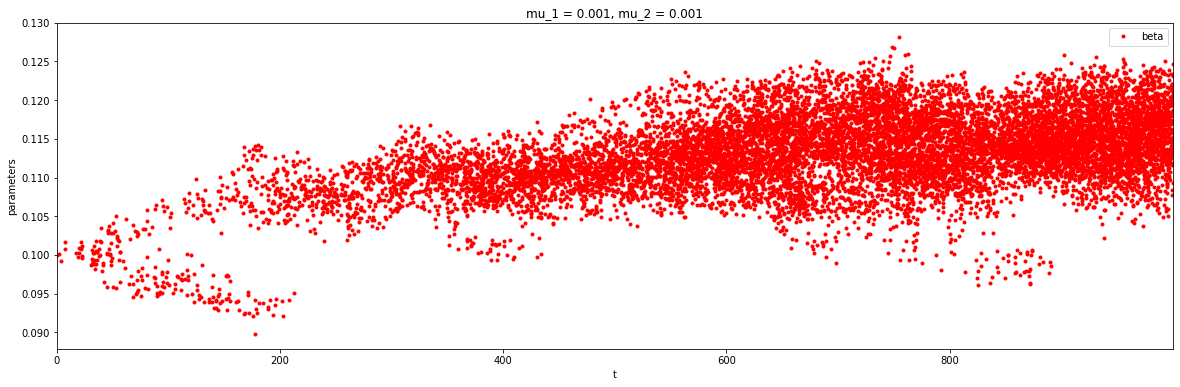

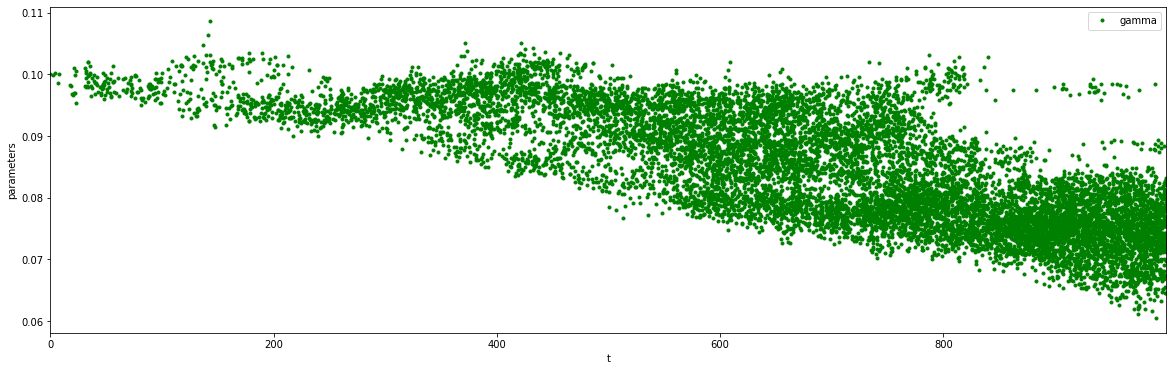

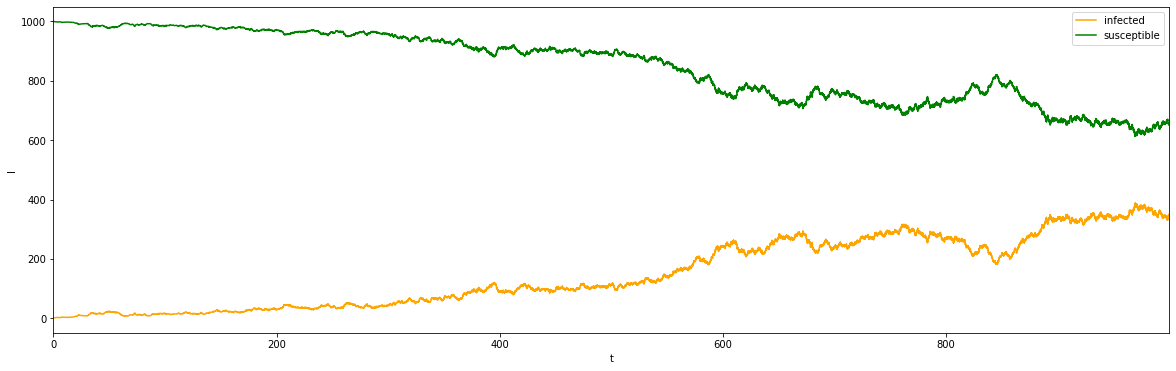

In [116]:
#parameters
S_0 = 1000
beta_0 = 0.1
gamma_0 = 0.1
mu_1 = 0.001
mu_2 = 0.001
t_thresh = 1000

s = None

while True:
    s = sim_finite(S_0, beta_0, gamma_0, mu_1, mu_2, t_thresh)
    if s.times[-1] > 50: break #get a simulation where the disease spreads for at least this many days
    #break
        
times = s.times; betas = s.betas; gammas = s.gammas; I = s.I; S = s.S

print(s.outcome)

#plot betas over time
plt.figure(figsize=(20,6))
plt.plot(times, betas, ".r", label='beta')
plt.title('mu_1 = {}, mu_2 = {}'.format(mu_1, mu_2))
plt.xlabel("t"); plt.ylabel("parameters")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(); plt.show()

#plot gammas over time
plt.figure(figsize=(20,6))
plt.plot(times, gammas, ".g", label='gamma')
plt.xlabel("t"); plt.ylabel("parameters")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(); plt.show()

#plot I and S over time
plt.figure(figsize=(20,6))
plt.plot(times, I, 'orange', label='infected')
plt.plot(times, S, 'green', label='susceptible')
plt.xlabel("t"); plt.ylabel("I")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(); plt.show()